Requirement Python >= 3.9, <3.12
numpy pandas geopands matplotlib overturemaps

In [2]:
import os
import numpy as np
import overturemaps
from matplotlib.colors import LogNorm

import pandas as pd
import geopandas as gpd

from shapely import wkt

from sklearn.neighbors import KDTree
from collections import Counter

import matplotlib.pyplot as plt

# Readin

In [6]:
# Seattle: -122.459681,47.481002,-122.224433,47.734124
# phoenix: -112.324024,33.2866,-111.925531,33.835285
# "boston": (-71.191244,42.227911,-70.804488,42.398397),
# 'neworleans': (-90.139931,29.865481,-89.625176,30.199469),
# 'chicago': (-87.947041,41.644531,-87.507176,42.027898),
# 'sanfrancisco': (-122.588041,37.640314,-122.314319,37.872715),
# 'austin': (-97.963384,30.108672,-97.515982,30.528434),
# 'Portland': (-122.844401,45.432536,-122.462353,45.652881),
# 'lasvagas': (-115.424285,36.129554,-115.047765,36.380841),
# 'atlanta': (-84.554658,33.643486,-84.27761,33.894409),
# 'philadelphia': (-75.263678,39.857742,-74.942691,40.162323),
# 'denver': (-105.107521,39.614301,-104.597038,39.914209),
# 'milwaukee': (-88.083329,42.917583,-87.862713,43.200599),
# 'dallas': (-97.004362,32.607435,-96.458056,33.030895),
# 'honolulu': (-157.958936,21.251871,-157.64725,21.417626),
# 'washington': (-77.126045,38.809118,-76.909366,38.995968),
# 'pittsburgh': (-80.103409,40.356907,-79.855674,40.510469),
# 'miami': (-80.331633,25.690735,-80.144382,25.8622),
# 'minneapolis': (-93.351989,44.881437,-93.192083,45.056012),
# 'new-york-city-boroughs': (-74.047736,40.674144,-73.884672,40.901888),
# "Tompkings": (-76.696267,42.262698,-76.237364,42.627418),

# cities are defined by a bounding box where all features of the specified bounding box will be collected
# bounding box for each city is listed above and can be found using the tool linked above
# one city at a time
locs = {
  "manhattan": (-74.0300, 40.7000, -73.9070, 40.8830),
}
# Specification:
# Building -- must be polygons, has area and height as key attributes. Think about using centroid for buildings, they are so tiny anyways
# Places -- must be points
# Transportation -- two types: segments and connectors. Segments must be linestring.
# land_use and infrastructure: supplementary classes.
# Not using: addresses, overlaps with buildings, incomplete data

data_dir = 'Overture'

In [7]:
for c_name, bbox in locs.items():
  building_gdf = overturemaps.core.geodataframe("building", bbox)
  building_gdf.set_crs(epsg=4326, inplace=True)

  filename = f"{c_name}_building.csv"
  csv_file_path = os.path.join(data_dir, filename)
  if not os.path.exists(csv_file_path):
    # Save the existing CSV file
    #building_gdf.fillna(1, inplace=True)
    building_gdf = building_gdf.filter(items=['id', 'names', 'subtype', 'class', 'height','is_underground', 'geometry'])
    # calculated area in meter square
    df_projected = building_gdf.to_crs(epsg=3857)
    building_gdf.to_crs(epsg=4326, inplace=True)
    building_gdf['area'] = df_projected['geometry'].area
    building_gdf['capacity'] = building_gdf['area'] * building_gdf['height']
    building_gdf['centroid'] = building_gdf.geometry.centroid
    building_gdf['lon'] = building_gdf.centroid.x
    building_gdf['lat'] = building_gdf.centroid.y
    building_gdf.to_csv(csv_file_path, index=False)
    print(f"done saving building data for {c_name}")


C:\Users\Acid\AppData\Local\Temp\ipykernel_3232\3781095914.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  building_gdf['centroid'] = building_gdf.geometry.centroid
C:\Users\Acid\AppData\Local\Temp\ipykernel_3232\3781095914.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  building_gdf['lon'] = building_gdf.centroid.x
C:\Users\Acid\AppData\Local\Temp\ipykernel_3232\3781095914.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  building_gdf['lat'] = building_gdf.centroid.y


done saving building data for manhattan


In [8]:
building_gdf.dtypes

id                  object
names               object
subtype             object
class               object
height             float64
is_underground        bool
geometry          geometry
area               float64
capacity           float64
centroid          geometry
lon                float64
lat                float64
dtype: object

# Preprocess

In [12]:
df = pd.read_csv('Overture/manhattan_building.csv')
df['geometry'] = df['geometry'].apply(wkt.loads)

df_all = gpd.GeoDataFrame(df, geometry='geometry')


In [13]:
df_all

,id,names,subtype,class,height,is_underground,geometry,area,capacity,centroid,lon,lat
0,08b2a10728051fff020099f7d2c82277,"{'primary': 'Battery Gardens', 'common': None,...",commercial,NaN,11.6,False,"POLYGON ((-74.01494 40.70155, -74.01501 40.701...",1633.068424,18943.593718,POINT (-74.01502003527102 40.701390417295805),-74.015020,40.701390
1,08b2a10728013fff02005c6ac451c48c,"{'primary': ""American Merchant Mariners' Memor...",NaN,NaN,3.0,False,"POLYGON ((-74.0178 40.70402, -74.01782 40.7039...",24.062972,72.188916,POINT (-74.01780337020173 40.703991025712185),-74.017803,40.703991
2,08b2a107280e6fff0200dbc192a49f93,NaN,NaN,NaN,3.5,False,"POLYGON ((-74.0172 40.70283, -74.01718 40.7028...",6.047820,21.167371,POINT (-74.01719730892064 40.702836881247435),-74.017197,40.702837
3,08b2a1072801bfff020050db7424292c,NaN,NaN,NaN,NaN,False,"POLYGON ((-74.0172 40.70293, -74.01726 40.7030...",103.881190,NaN,POINT (-74.01726180964414 40.70295968162952),-74.017262,40.702960
4,08b2a10728050fff0200feb3640b3c51,"{'primary': 'Pixie Scout Canteen', 'common': N...",commercial,NaN,NaN,False,"POLYGON ((-74.01551 40.70178, -74.01552 40.701...",58.144666,NaN,POINT (-74.01549677453973 40.70175536284051),-74.015497,40.701755
...,...,...,...,...,...,...,...,...,...,...,...,...
161231,08b2a100a1935fff0200af0ac57e212e,NaN,NaN,NaN,8.2,False,"POLYGON ((-73.90704 40.88284, -73.907 40.88287...",142.356210,1167.320921,POINT (-73.9070866028939 40.88290019549333),-73.907087,40.882900
161232,08b2a100a1935fff0200ba1dd9b34757,NaN,NaN,NaN,8.2,False,"POLYGON ((-73.907 40.88287, -73.90695 40.88291...",154.914371,1270.297844,POINT (-73.90704475000001 40.88293645),-73.907045,40.882936
161233,08b2a100a1935fff020088b472745938,NaN,NaN,NaN,8.2,False,"POLYGON ((-73.90695 40.88291, -73.90691 40.882...",143.402157,1175.897684,POINT (-73.90700276751623 40.88297283903405),-73.907003,40.882973
161234,08b2a100a1935fff0200b406aca4d820,NaN,NaN,NaN,8.2,False,"POLYGON ((-73.90687 40.88298, -73.90687 40.882...",152.824909,1253.164255,POINT (-73.90696100452134 40.88300890423539),-73.906961,40.883009


In [14]:
df_all['subtype'].unique()

array(['commercial', nan, 'service', 'outbuilding', 'transportation',
       'religious', 'civic', 'residential', 'education', 'entertainment',
       'medical', 'industrial', 'agricultural'], dtype=object)

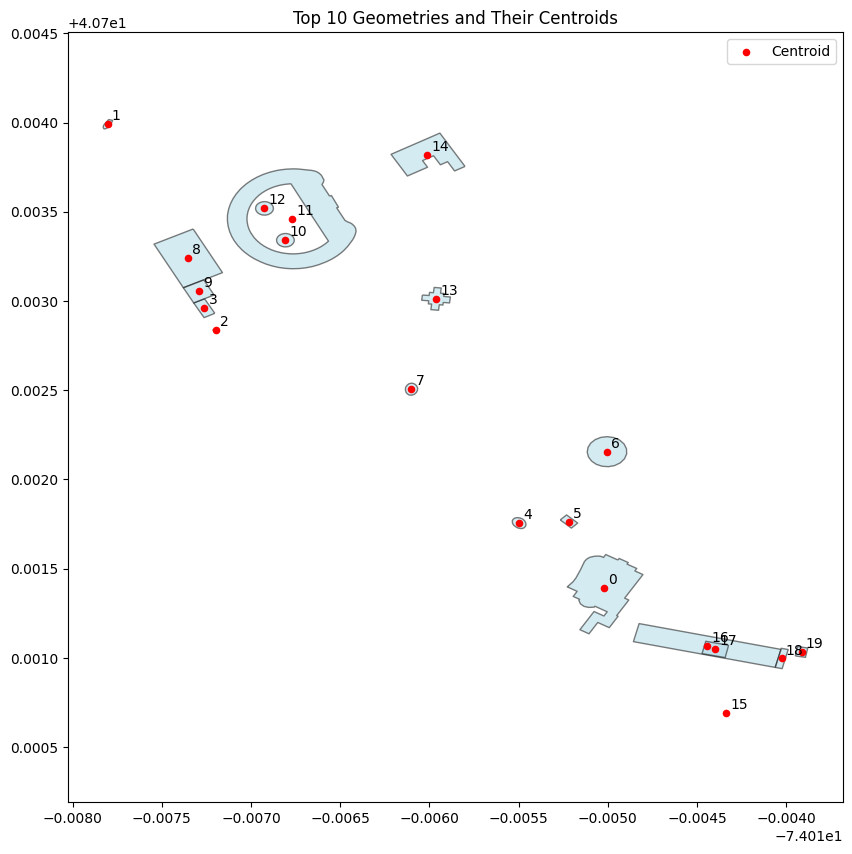

In [15]:
fig, ax = plt.subplots(figsize=(10, 10))
df_all.head(20).plot(ax=ax, edgecolor='black', facecolor='lightblue', alpha=0.5)
df_all.head(20).centroid.plot(ax=ax, color='red', markersize=20, label='Centroid')

for idx, row in df_all.head(20).iterrows():
    ax.annotate(f"{idx}", xy=(row['lon'], row['lat']), xytext=(3, 3), textcoords='offset points')

ax.set_title("Top 10 Geometries and Their Centroids")
ax.legend()
plt.axis('equal')
plt.show()

In [16]:
raw_counts

NameError: name 'raw_counts' is not defined

In [17]:
raw_counts

NameError: name 'raw_counts' is not defined

In [18]:
df_known   = df_all[df_all['subtype'].notnull()].copy()
df_unknown = df_all[df_all['subtype'].isnull()].copy()

dist       = df_known['subtype'].value_counts(normalize=True)
raw_counts = dist * len(df_all)

target_counts = raw_counts.round().astype(int)
delta = len(df_all) - target_counts.sum()

if delta > 0:
    fracs = (raw_counts - np.floor(raw_counts)).sort_values(ascending=False)
    for tag in fracs.head(delta).index:
        target_counts[tag] += 1
elif delta < 0:
    fracs = (raw_counts - np.floor(raw_counts)).sort_values()
    for tag in fracs.head(-delta).index:
        target_counts[tag] -= 1

assigned_so_far = df_known['subtype'].value_counts()
needed_tags = (target_counts - assigned_so_far).clip(lower=0).to_dict()

In [19]:
known_coords = df_known[['lat', 'lon']].values
unknown_coords = df_unknown[['lat', 'lon']].values
tree = KDTree(known_coords, leaf_size=40)

df_unknown['predicted_type'] = None
known_types = df_known['subtype'].values
RADIUS = 0.01  # ~1km

counters = 0

spatial_rule_tags = {'residential', 'commercial', 'industrial', 'service'}

def vote_based_on_neighbors(idx, k_neighbors_idx, known_types):
    neighbors = known_types[k_neighbors_idx]
    counts = Counter(neighbors)

    if counts['residential'] >= 2:
        return 'residential'
    elif counts['commercial'] >= 1:
        return 'commercial'
    elif counts['industrial'] >= 1 and counts['service'] >= 1:
        if counts['residential'] >= 50:
            return 'service'
        else:
            return 'industrial'
    elif counts['industrial'] >= 1 and counts['residential'] == 0:
        return 'industrial'
    elif counts['service'] >= 1 or counts['residential'] >= 1:
        return 'service'
    return None

for i, coord in enumerate(unknown_coords):
    if all(needed_tags.get(t, 0) == 0 for t in spatial_rule_tags):
        print("No more tags needed, stopping early")
        break

    idx = tree.query_radius([coord], r=RADIUS, return_distance=False)[0]
    if len(idx) == 0:
        continue

    suggested_type = vote_based_on_neighbors(i, idx, known_types)
    if suggested_type and needed_tags.get(suggested_type, 0) > 0:
        df_unknown.iloc[i, df_unknown.columns.get_loc('predicted_type')] = suggested_type
        needed_tags[suggested_type] -= 1

In [20]:
remaining_unknown = df_unknown[df_unknown['predicted_type'].isnull()].copy()
non_rule_tags = [t for t in dist.index if t not in spatial_rule_tags]

remaining_needed = {
    t: needed_tags[t] for t in dist.index if needed_tags.get(t, 0) > 0
}



In [21]:
assign_list = []
for tag, count in remaining_needed.items():
    assign_list += [tag] * count

np.random.shuffle(assign_list)

n = min(len(assign_list), len(remaining_unknown))
df_unknown.loc[remaining_unknown.index[:n], 'predicted_type'] = assign_list[:n]

df_all.loc[df_unknown.index, 'subtype'] = df_unknown['predicted_type']

In [25]:
from pygris import counties
ny_counties = counties(state="NY", cb=True, year=2023)          # generalized boundary
manhattan = ny_counties[ny_counties["GEOID"] == "36061"].to_crs("EPSG:4326")


if df_all.geom_type.isin(["Point", "MultiPoint"]).all():
    gdf_in_manhattan = gpd.sjoin(df_all, manhattan[["GEOID","geometry"]], predicate="within")
else:
    gdf_in_manhattan = df_all.clip(manhattan)


Using FIPS code '36' for input 'NY'


c:\Users\Acid\Desktop\Project\.venv\lib\site-packages\geopandas\geodataframe.py:2585: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: None
Right CRS: EPSG:4326

  return geopandas.clip(self, mask=mask, keep_geom_type=keep_geom_type, sort=sort)


In [26]:
gdf_in_manhattan.to_csv('Overture/Manhattan_Output_Building_Dataset.CSV', index=False)